In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Import Libraries

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from sklearn.preprocessing import  MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
     BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.preprocessing import PowerTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier

from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 
import joblib


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/water_potability.csv').dropna()
data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
...,...,...,...,...,...,...,...,...,...,...
3267,8.989900,215.047358,15921.412018,6.297312,312.931022,390.410231,9.899115,55.069304,4.613843,1
3268,6.702547,207.321086,17246.920347,7.708117,304.510230,329.266002,16.217303,28.878601,3.442983,1
3269,11.491011,94.812545,37188.826022,9.263166,258.930600,439.893618,16.172755,41.558501,4.369264,1
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ph,2011.0,7.085990,1.573337,0.227499,6.089723,7.027297,8.052969,14.000000
Hardness,2011.0,195.968072,32.635085,73.492234,176.744938,197.191839,216.441070,317.338124
Solids,2011.0,21917.441374,8642.239815,320.942611,15615.665390,20933.512750,27182.587067,56488.672413
Chloramines,2011.0,7.134338,1.584820,1.390871,6.138895,7.143907,8.109726,13.127000
Sulfate,2011.0,333.224672,41.205172,129.000000,307.632511,332.232177,359.330555,481.030642
Conductivity,2011.0,426.526409,80.712572,201.619737,366.680307,423.455906,482.373169,753.342620
Organic_carbon,2011.0,14.357709,3.324959,2.200000,12.124105,14.322019,16.683049,27.006707
Trihalomethanes,2011.0,66.400859,16.077109,8.577013,55.952664,66.542198,77.291925,124.000000
Turbidity,2011.0,3.969729,0.780346,1.450000,3.442915,3.968177,4.514175,6.494749
Potability,2011.0,0.403282,0.490678,0.000000,0.000000,0.000000,1.000000,1.000000


In [6]:
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [7]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


### 3.2. Get columns dtypes

In [8]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']
Categorical Columns : []


### 3.3. EDA

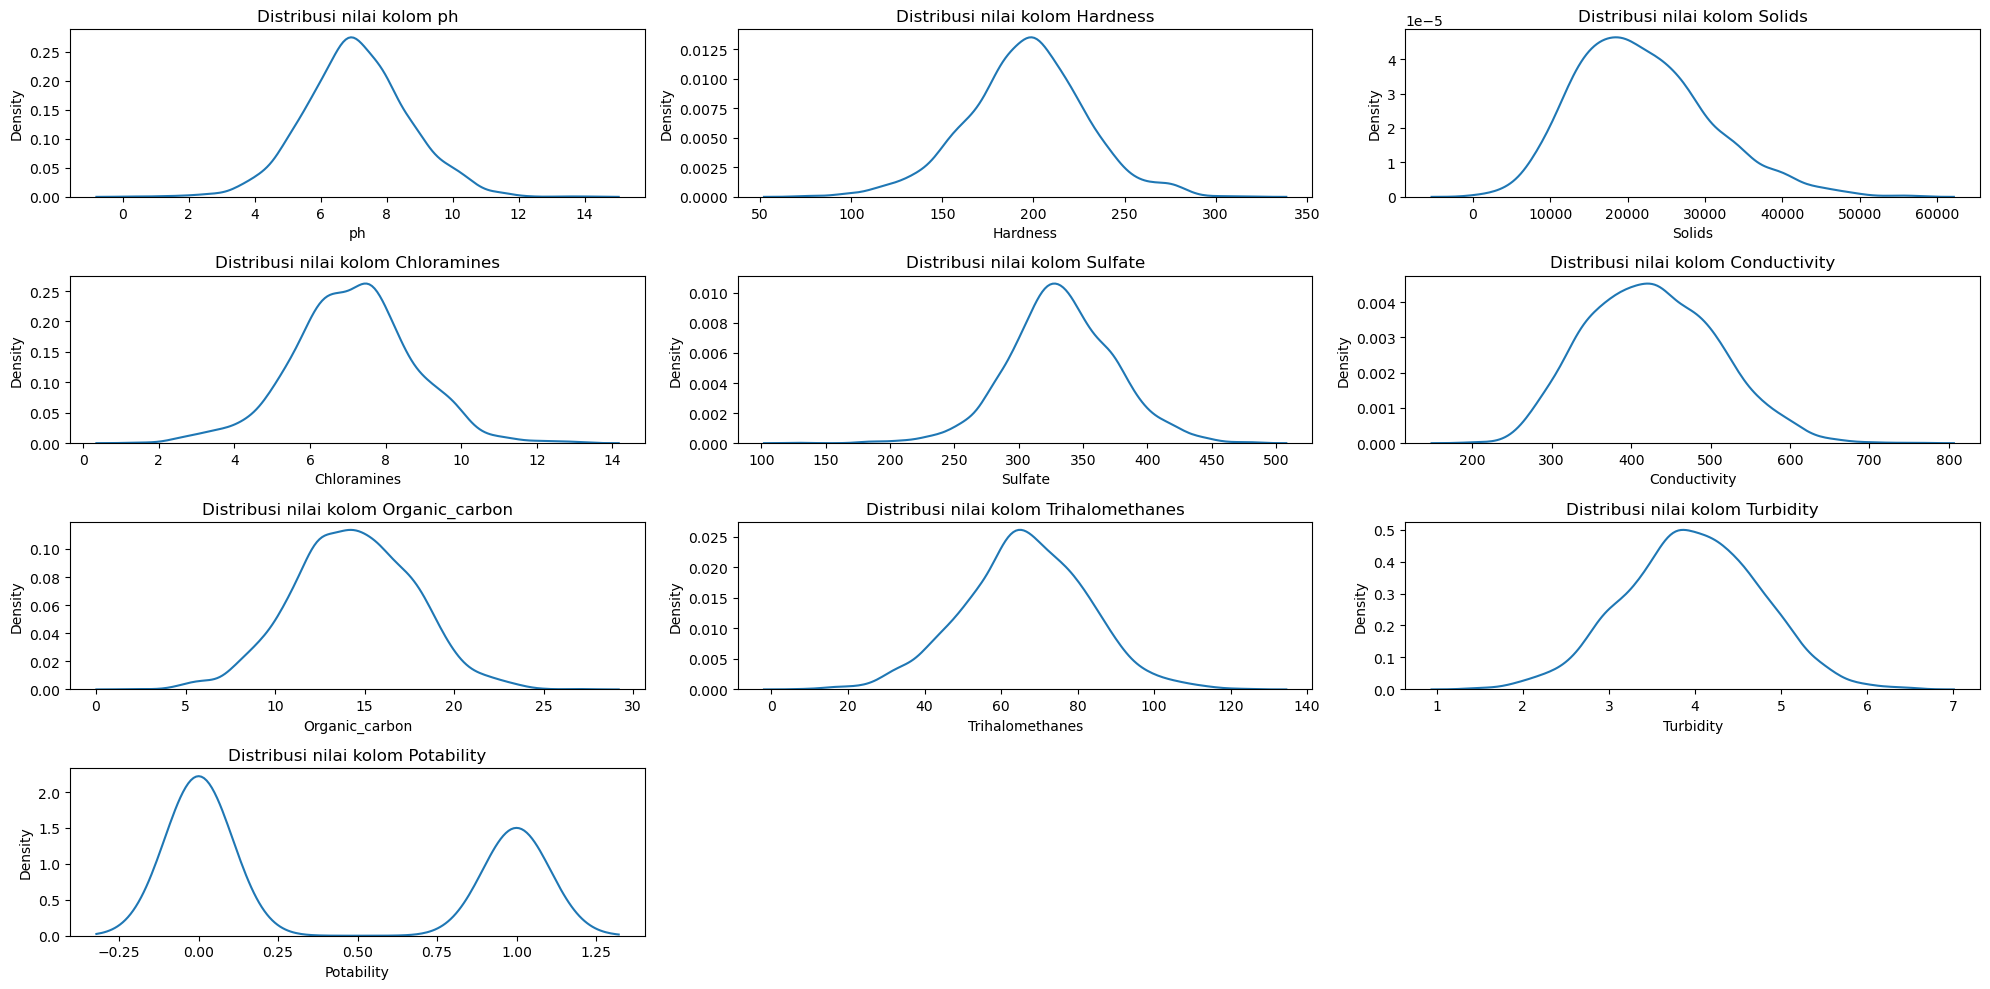

In [10]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

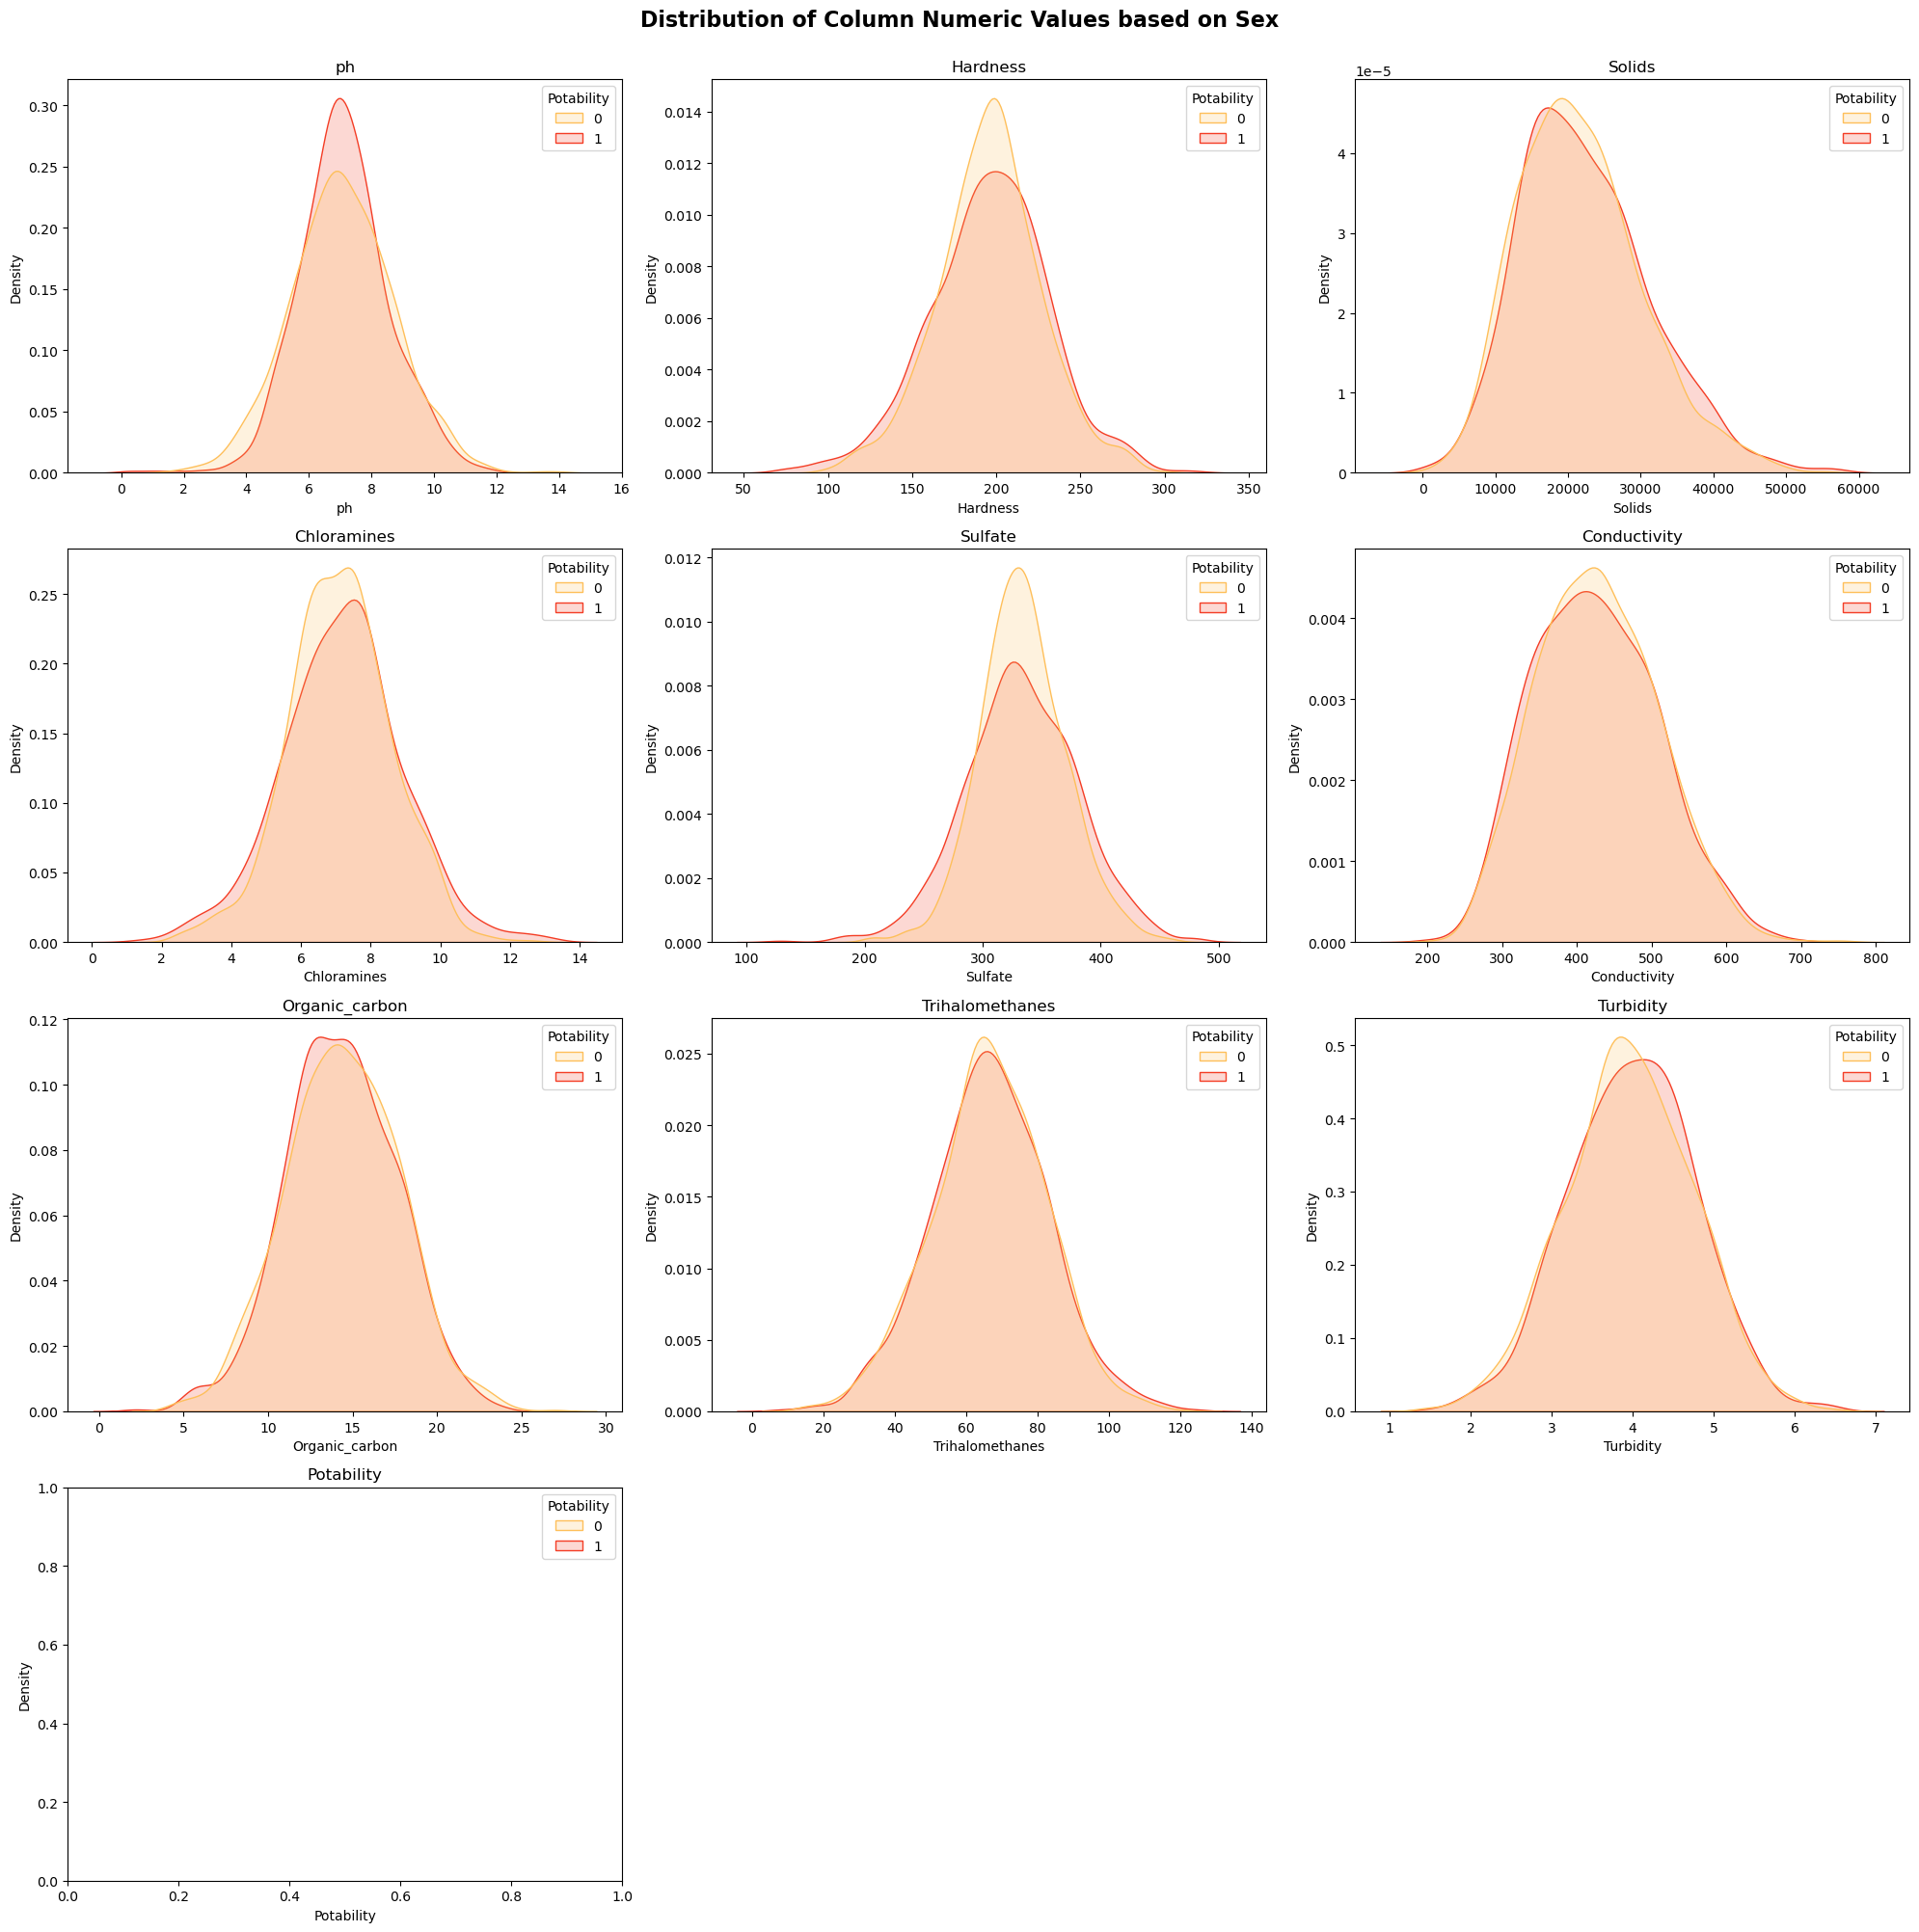

In [12]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="Potability", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Sex', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

[Text(0, 0, '1200'), Text(0, 0, '811')]

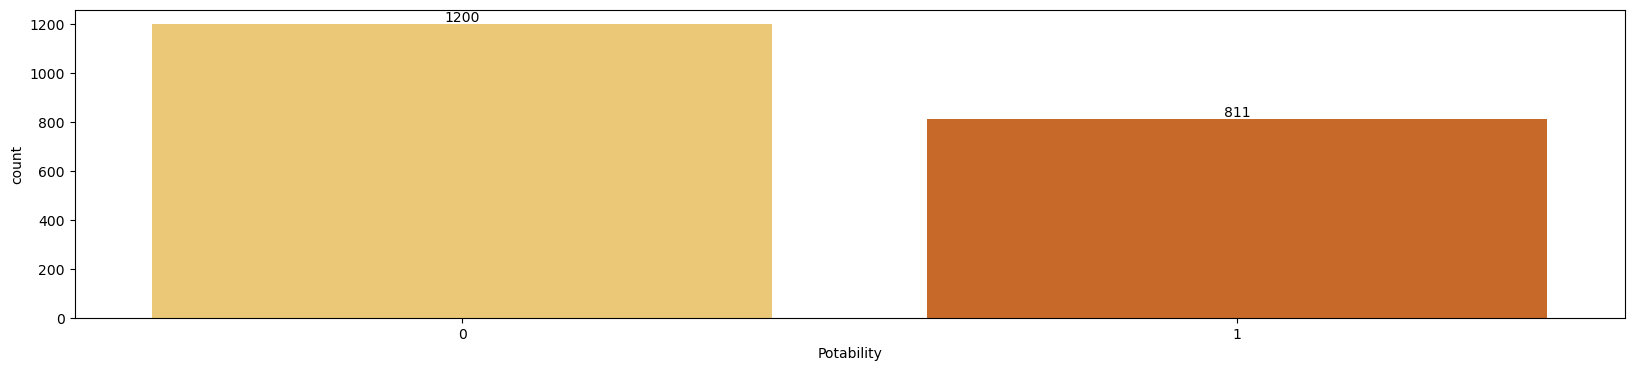

In [14]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'Potability', palette='YlOrBr')
ax.bar_label(ax.containers[0])

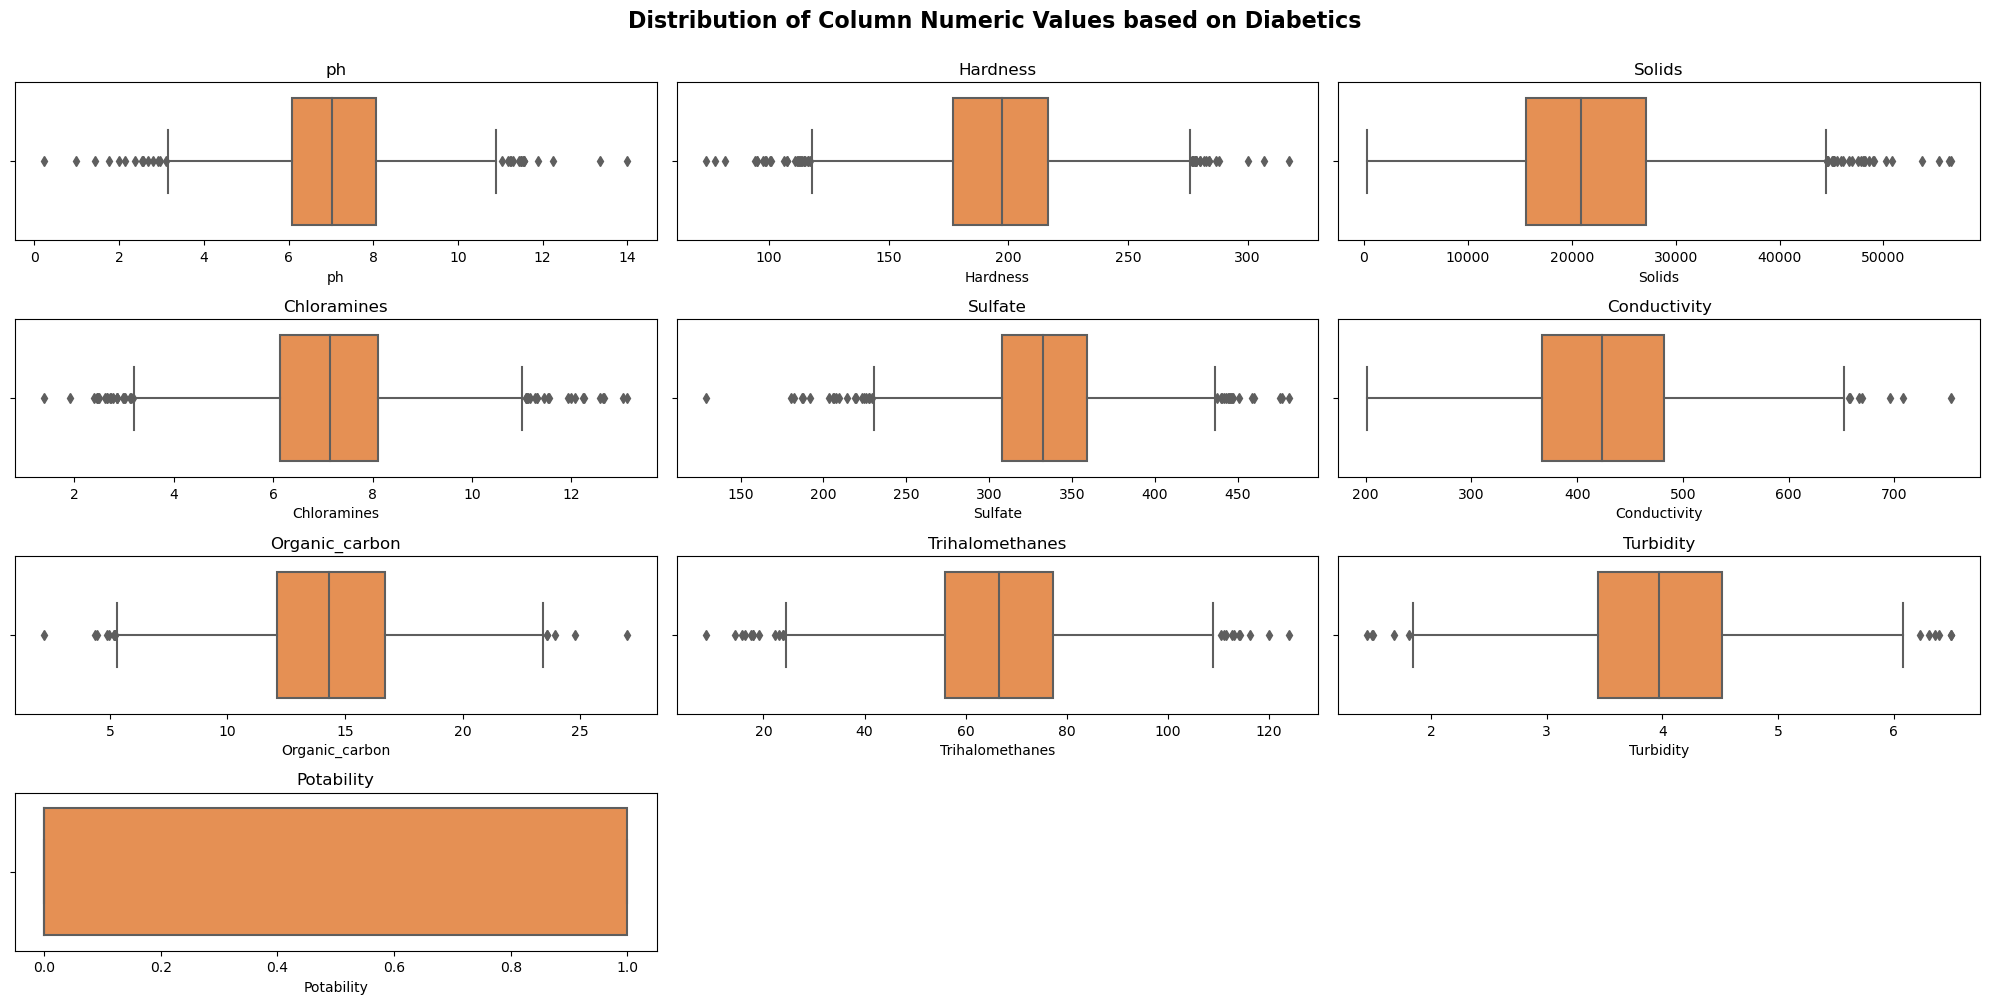

In [16]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Diabetics', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

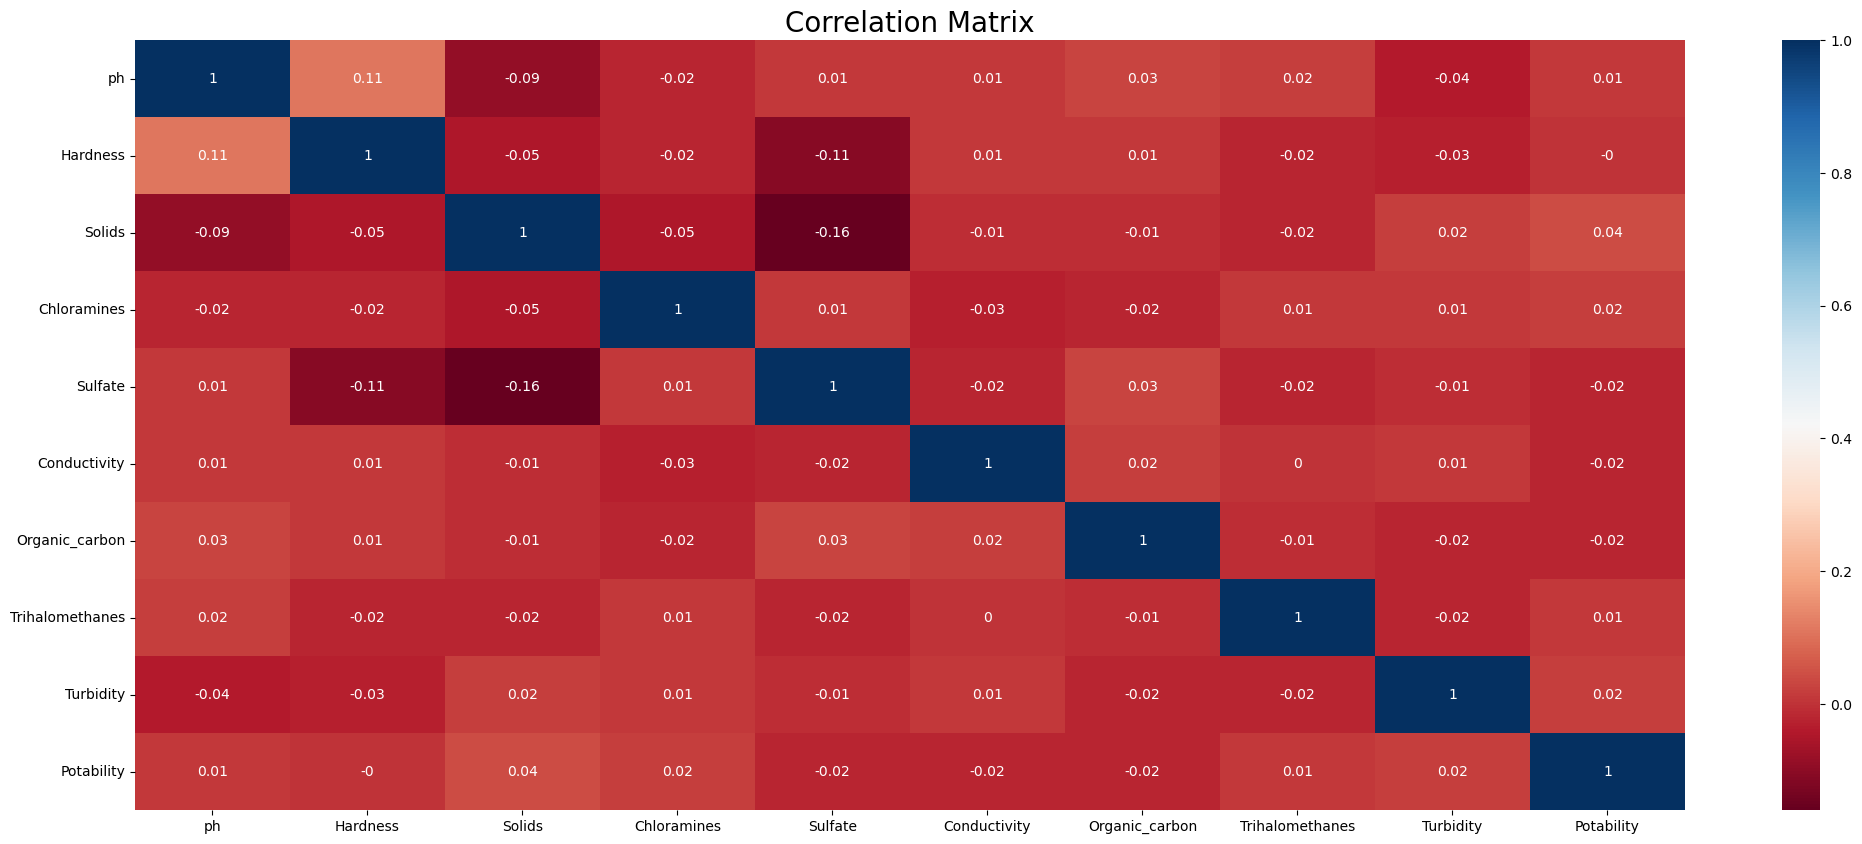

In [18]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.2. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Splitting Train, Test, And Validation data 

In [21]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

# print(Counter(Y))
# undersample = RandomUnderSampler()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

# Y = to_categorical(Y)

# scaler = MinMaxScaler(feature_range=(0,1))
# X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
X_val = scalar.transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1411, 9)
(398, 9)
(202, 9)


### 4.3. Neural Network Algoritms

In [72]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(4096, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def CNN_Model():
    model = Sequential()

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(16, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add((LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add((LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(1, activation='sigmoid'))
    return model
    

model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.001)

# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 4096)              40960     
                                                                 
 dense_45 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_46 (Dense)            (None, 256)               262400    
                                                                 
 dense_47 (Dense)            (None, 1)                 257       
                                                                 
Total params: 4,498,945
Trainable params: 4,498,945
Non-trainable params: 0
_________________________________________________________________


In [73]:
num_epoch = 10
batch_size = 32

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

Epoch 1/10
45/45 [==============================] - 1s 12ms/step - loss: 0.6799 - accuracy: 0.5911 - val_loss: 0.6543 - val_accuracy: 0.6080
Epoch 2/10
45/45 [==============================] - 0s 5ms/step - loss: 0.6087 - accuracy: 0.6733 - val_loss: 0.6255 - val_accuracy: 0.6658
Epoch 3/10
45/45 [==============================] - 0s 5ms/step - loss: 0.5838 - accuracy: 0.6974 - val_loss: 0.6524 - val_accuracy: 0.6608
Epoch 4/10
45/45 [==============================] - 0s 5ms/step - loss: 0.5852 - accuracy: 0.6967 - val_loss: 0.6276 - val_accuracy: 0.6658
Epoch 5/10
45/45 [==============================] - 0s 5ms/step - loss: 0.5673 - accuracy: 0.7172 - val_loss: 0.6415 - val_accuracy: 0.6432
Epoch 6/10
45/45 [==============================] - 0s 5ms/step - loss: 0.5574 - accuracy: 0.7045 - val_loss: 0.6630 - val_accuracy: 0.6307
Epoch 7/10
45/45 [==============================] - 0s 5ms/step - loss: 0.5367 - accuracy: 0.7300 - val_loss: 0.6470 - val_accuracy: 0.6709
Epoch 8/10
45/45 [=

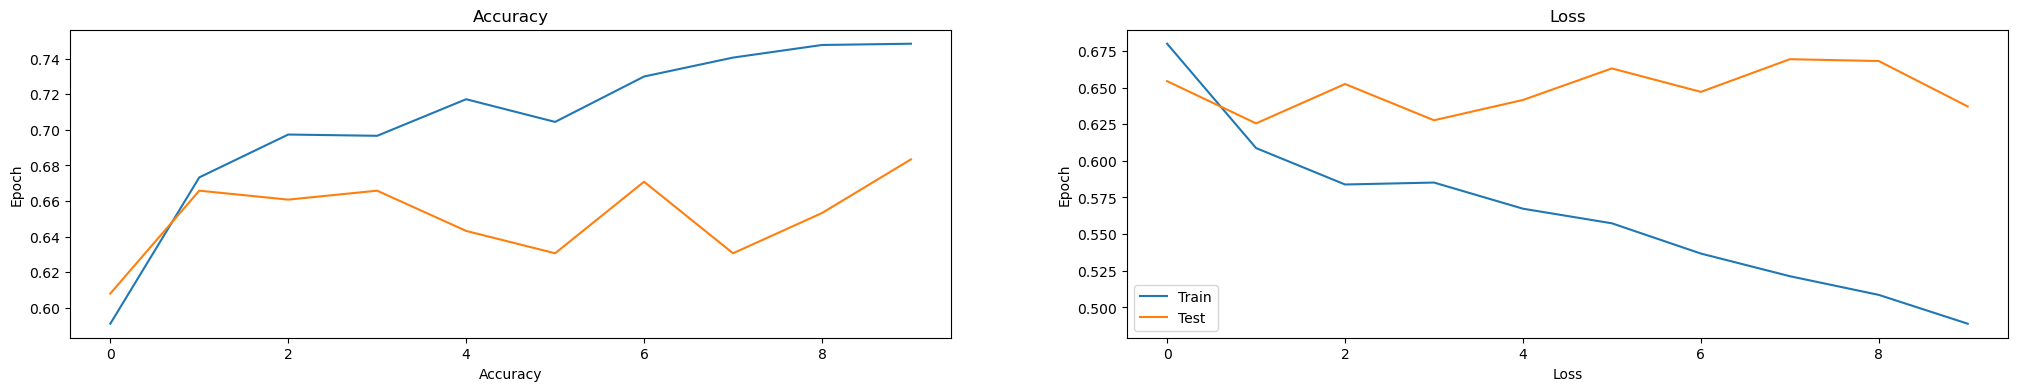

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [75]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(X_val))

print(classification_report(y_val,y_pred))

7/7 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.71      0.80      0.76       123
           1       0.62      0.49      0.55        79

    accuracy                           0.68       202
   macro avg       0.67      0.65      0.65       202
weighted avg       0.68      0.68      0.67       202



7/7 [==============================] - 0s 10ms/step


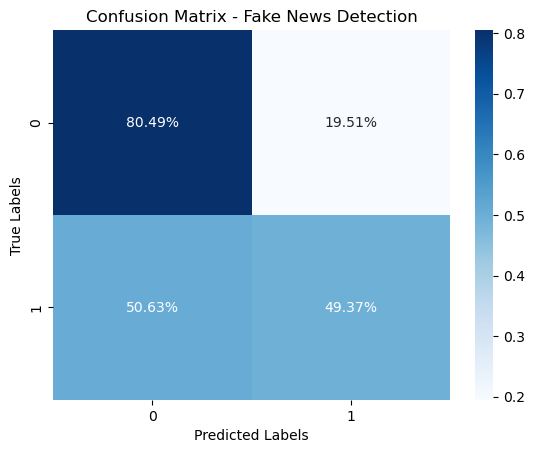

In [76]:
# labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(X_val))
# Build confusion matrix
con_mat = confusion_matrix(y_val,y_pred)

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

### 4.4. Supervised Learning

In [59]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)

model = StackingClassifier([
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('gradient', gradient),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB),
    ('knn', knn),
    ('decisionTree', decisionTree),
], n_jobs=-1)

In [60]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('gradient',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=100,
                                                           random_state=42)),
                               ('randomforest',
                                RandomForestClassifier(max_de...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('knn', KNeighborsClassifier(n_jobs=-1)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       random_state=42))],
                   n_jobs=-1)

In [61]:
print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')
print("Val Score   : ",round((model.score(X_val, y_val)*100), 2),'%')

Train Score :  100.0 %
Test Score  :  67.34 %
Val Score   :  69.31 %


In [70]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      3510
           1       0.78      0.78      0.78      3584
           2       0.63      0.62      0.62      3496

    accuracy                           0.73     10590
   macro avg       0.73      0.73      0.73     10590
weighted avg       0.73      0.73      0.73     10590



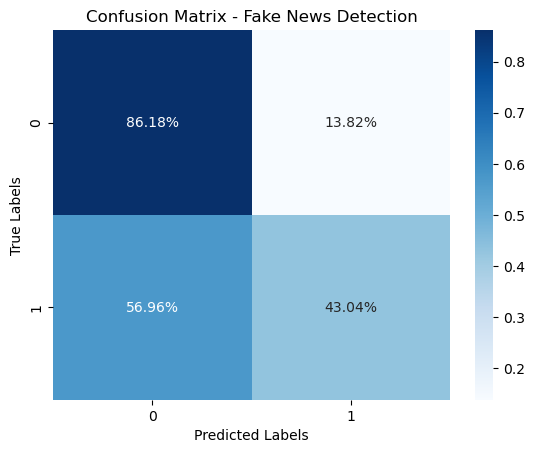

In [62]:
# labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(X_val))
# Build confusion matrix
con_mat = confusion_matrix(y_val,y_pred)

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()